# Python is for science!

There are many cool libraries available to you in Python. These include `numpy` and `matplotlib` (used in this notebook) and scipy. `numpy`, which accesses very fast compiled code, is particularly good for numerical computing, `matplotlib` allows the quick production of visually appealing and useful plots (many of the plots you will see nowadays are produced with matplotlib), and `scipy` contains an array of scientific functionality. All of these are installed on the Docker container you downloaded and you will see them in use in the workshops this week.

In this notebook, we aren't hoping to preempt the other sessions, but will proceed through some useful tasks you might wish to do from time to time, demonstrating reading from `PSRFITS` files, inspecting the header, putting the binary data into a numpy array, plotting a dynamic spectrum and then manipulating the plot to enhance clarity of the displayed output. The file in question is in the same directory as this notebook; it's a small file (already subbanded) of a bright pulsar, taken at Arecibo Observatory with `puppi`, in search mode.

## Import statements

Here we import the useful stuff. `numpy` is nearly always aliased as `np` and `astropy.io.fits` is often aliased as `pyfits` because `pyfits` is an older package, used in a lot of legacy code, that was rolled into `astropy`'s `astropy.io.fits` module (using this alias means that a lot of that old code still works!). The `cm` module in `matplotlib` is for colormaps, and the `pyplot` provides us with a plotting functionality similar to that in `MATLAB`. Lastly, the `%matplotlib inline` directive, which is specific to `Jupyter`, lets us plot inside the notebook cells rather than popping up a fresh window for each plot.

It's really very impressive, how much cool functionality is given to use by just importing those few modules.

In [1]:
%matplotlib inline
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Do you have the file?

We use a Jupyter directive to get a list of the files in the current working directory:

In [1]:
!ls

Basic_basics.ipynb		     Loops_ifs_files.ipynb
Faking_it_at_the_command_line.ipynb  Numpy_and_you.ipynb
Functions.ipynb			     Python2_and_Python3_Some__future__.ipynb
getting_stuff_done.ipynb	     some_pulsars.txt


If `puppi_57166_J1404+12_1326_subs_0001.fits` isn't in there, you need to get it:

In [2]:
!wget http://ipta.phys.wvu.edu/files/student-week-2018/puppi_57166_J1404+12_1326_subs_0001.fits

--2018-06-08 19:41:08--  http://ipta.phys.wvu.edu/files/student-week-2018/puppi_57166_J1404+12_1326_subs_0001.fits
Resolving ipta.phys.wvu.edu (ipta.phys.wvu.edu)... 157.182.3.45
Connecting to ipta.phys.wvu.edu (ipta.phys.wvu.edu)|157.182.3.45|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285373440 (272M) [application/octet-stream]
Saving to: ‘puppi_57166_J1404+12_1326_subs_0001.fits’

puppi_57166_J1404+1 100%[===================>] 272.15M  5.75MB/s    in 61s     

2018-06-08 19:42:11 (4.48 MB/s) - ‘puppi_57166_J1404+12_1326_subs_0001.fits’ saved [285373440/285373440]



## Load the fits file via astropy

Sometimes PSRFITS files are missing the END card so we set `ignore_missing_end = True` just in case. This is something which can save you frustrating errors, particularly when running a pipeline on very many files. The file is in the same directory as this notebook; as mentioned above, it's a subbanded search-mode file of a bright pulsar; the period of this pulsar, `J1404+12`, is around ~2.65 seconds and the DM is 18.836.

You can read the `astropy.io.fits` documentation, with examples, [at this page](http://docs.astropy.org/en/stable/io/fits/) (where you also see how to use it if you aren't aliasing to `pyfits`)

In [2]:
#Should include full filepath if it's not in the local directory
filename = "puppi_57166_J1404+12_1326_subs_0001.fits"
#the open function returns a list of the Header/Data Units (HDUs) in the file
hdulist = pyfits.open(filename,ignore_missing_end=True)

## Look at the data shape

Sometimes you don't know what to expect, so this is how you can see what's in the FITS file. The first HDU is the `PRIMARY` HDU. The basic FITS standard is explained briefly [here](https://fits.gsfc.nasa.gov/fits_primer.html), but PSRFITS is an extension of this (and in some cases, the data values are encoded with less than 8 bits and packed into 8 bit `ints`, which means they need to be unpacked; this file, however, contains 8-bit values). Here we learn that there are two HDUs and get information about their contents.

The first thing you'll want to try to understand the structure of a FITS file is to use the `info()` function, like so:

In [3]:
# Show useful information about the tables in the FITS file
hdulist.info()

Filename: puppi_57166_J1404+12_1326_subs_0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  SUBINT        1 BinTableHDU     74   68R x 17C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 128E, 128E, 128E, 128E, 4194304B]   


You can see the names of the different tables; in this case there are two, `PRIMARY` and `SUBINT`, which you can either call by name like `hdulist['PRIMARY']` or number like `hdulist[0]`. There is always a primary header and then there can be multiple tables stores.

For any of the tables, you can use `TABLE.header` to grab header information. The header for `PRIMARY` is "the" header for the FITS file but tables can store their own headers. Let's look at the primary header:

In [4]:
# Show the header in the primary HDU: typically the observation parameters are in here
hdulist['PRIMARY'].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDRVER  = '3.4             '   / Header version                                 
FITSTYPE= 'PSRFITS '           / FITS definition for pulsar data files          
DATE    = '2015-07-14T22:36:02' / File creation date (YYYY-MM-DDThh:mm:ss UTC)  
OBSERVER= 'JD      '           / Observer name(s)                               
PROJID  = 'p2825   '           / Project name                                   
TELESCOP= 'Arecibo '           / Telescope name                                 
ANT_X   =            882589.

### Where is my data?

The data are in the `SUBINT` HDU. Let's first look at the header. You can see that there's a lot of different fields of information, what the shapes/formats of the data are, etc.

In [5]:
hdulist['SUBINT'].header

XTENSION= 'BINTABLE'           / ***** Subintegration data  *****               
BITPIX  =                    8 / N/A                                            
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =              4196428 / width of table in bytes                        
NAXIS2  =                   68 / Number of rows in table (NSUBINT)              
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   17 / Number of fields per row                       
TTYPE1  = 'TSUBINT '           / Length of subintegration                       
TFORM1  = '1D      '           / Double                                         
TTYPE2  = 'OFFS_SUB'           / Offset from Start of subint centre             
TFORM2  = '1D      '           / Double                                         
TTYPE3  = 'LST_SUB '        

For any table with data, you can use `TABLE.data` to grab the data. Let's look at the data

In [6]:
# Grab the data
data = hdulist['SUBINT'].data
# Look at the first subintegration
print(data[0])

(2.6843545600000001, 1.34217728, 51395.0, 211.167, 12.050000000000001, 355.21571931505582, 67.148819360727686, 0.0, 0.0, 0.0, 69.6129, 16.567699, array([ 292.88134766,  293.41845703,  293.95556641,  294.49267578,
        295.02978516,  295.56689453,  296.10400391,  296.64111328,
        297.17822266,  297.71533203,  298.25244141,  298.78955078,
        299.32666016,  299.86376953,  300.40087891,  300.93798828,
        301.47509766,  302.01220703,  302.54931641,  303.08642578,
        303.62353516,  304.16064453,  304.69775391,  305.23486328,
        305.77197266,  306.30908203,  306.84619141,  307.38330078,
        307.92041016,  308.45751953,  308.99462891,  309.53173828,
        310.06884766,  310.60595703,  311.14306641,  311.68017578,
        312.21728516,  312.75439453,  313.29150391,  313.82861328,
        314.36572266,  314.90283203,  315.43994141,  315.97705078,
        316.51416016,  317.05126953,  317.58837891,  318.12548828,
        318.66259766,  319.19970703,  319.73681641

You can try to match what's in the header to what's in the data table. You'll notice that the last element of this first subintegration is the full data array of pulse intensities. Before that are a bunch of other items that you can see in the header, such as the length of the subintegration (in units of seconds, note TUNIT1), the RA/dec position of the telescope, etc. Let's explicitly grab the length of the subintegration using the flag indicated in the header.

In [14]:
hdulist['SUBINT'].data['TSUBINT']

array([ 2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456,  2.68435456,  2.68435456,
        2.68435456,  2.68435456,  2.68435456])

So, each of the 68 subintegrations has 2.684 seconds worth of data. 

Now let's look at the shape of the intensity data. These shapes can be derived from the header as well but sometimes you'll just want to grab these in code rather than just printing them out

In [11]:
# number of subintegrations
print(np.shape(data))
# shape of each subintegration (the last value is the actual array of intensities)
# shape is in (time, polarization, frequency, phase)
print(np.shape(data[0][-1]))
# Remove the dimensions with only one value, which makes a dynamic spectrum in (time, frequency)
print(np.shape(data[0][-1].squeeze()))

(68,)
(32768, 1, 128, 1)
(32768, 128)


So, there are 68 subintegrations, each with about 2.684 seconds of data. In each of these subintegrations, there are 32768 time samples, 1 polarization, 128 frequency channels, and 1 phase bin. Note that since this is a search-mode observation rather than a fold-mode observation, there's no pulse period and so no phase!

## Plot the dynamic spectrum of the first subintegration

The dynamic spectrum shows the intensities as a function of time and frequency. Given the shape of the squeezed array above, that's very easy to do in matplotlib with the `imshow()` function. For convenience, we've added some useful arguments to the function. You can also pick your own [colormap](https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html)!

Side programming note: because you should think of a 2D array with indices as (row, column), which is like (y,x), to plot in (x,y), you'll often want to transpose the array as we have done below.

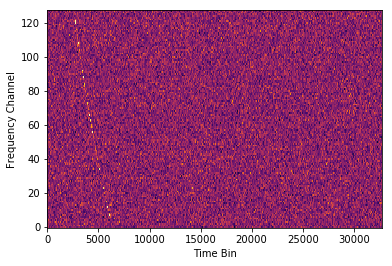

In [8]:
dynspec = data[0][-1].squeeze()
# Transpose the array to go from (row, column) -> (x,y)
plt.imshow(np.transpose(dynspec),origin='lower',interpolation='nearest',aspect='auto',cmap=cm.inferno)
plt.xlabel('Time Bin')
plt.ylabel('Frequency Channel')

## Reduce the array in time

The following is a simple function to average a 2D array in the first dimension (time in this case) by a certain factor. Then we will plot the reduced dynamic spectrum like above.

In [9]:
def timeaverager(array,window_len):
    if window_len==1:
        return array
    T,F = np.shape(array)
    retval = np.zeros((T//window_len,F)) #integer division in python 3!
    counts = np.zeros_like(retval)
    for i in range(window_len):
        retval += array[i:T:window_len,:]
    return retval/window_len

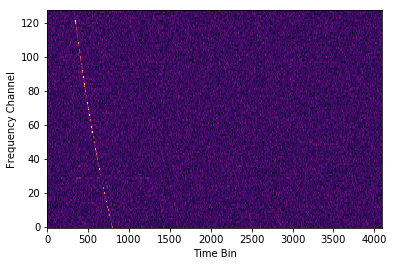

In [10]:
# Average down by a factor of 8 in time
avgdynspec = timeaverager(dynspec,8)
# Transpose the array to go from (row, column) -> (x,y)
plt.imshow(np.transpose(avgdynspec),origin='lower',interpolation='nearest',aspect='auto',cmap=cm.inferno)
plt.xlabel('Time Bin')
plt.ylabel('Frequency Channel')